# Pro Cam Scan

## Setup Docker (local)
This can run in docker on a mac. Remember to bump the available memory and CPU in docker settings, and restart Docker.

Build image

```
 docker build --rm -t jupyter/lightleaks-notebook .
```

Run image
```
docker run -p 8888:8888 \
-v "$PWD/":/home/jovyan/Lightleaks  \
-v "$PWD/../SharedData/":/home/jovyan/SharedData  \
jupyter/lightleaks-notebook
```



## Setup GCE
Notes for setting up on a GCE instance (Ubuntu 16.04). This notebook wont run with the free colab instance

### Connect to GCE instance 

```ssh -i $HOME/.ssh/google_compute_engine jongejan@<IP> -L 8888:localhost:8888 ```

### Setup dependencies:
```
wget https://repo.anaconda.com/archive/Anaconda3-5.2.0-Linux-x86_64.sh
bash Anaconda3-5.2.0-Linux-x86_64.sh
pip install jupyter_http_over_ws
jupyter serverextension enable --py jupyter_http_over_ws
gcloud init
```

### Start
```jupyter notebook   --NotebookApp.allow_origin='https://colab.research.google.com'   --no-browser  --port=8888```



### Upload data:
```gsutil -m rsync -r SharedData/ gs://lightleaks/todaysart/```

Interesting things I noticed:
- Color is a subtle indicator of edge reflections.
- It should be possible to know that the gray area between white and black belongs to both white and black.
- Highpass is only helpful for calculating the confidence, not useful for building the map.

In [24]:
#@title Settings { run: "auto" }

# SETTINGS
blur_distance = 301
processing_name = 'promap-'+str(blur_distance)

LOCAL = True

if LOCAL:
    #jovyan is user on Docker image
    data_dir = '/home/jovyan/SharedData' 
else:
    bucket = 'lightleaks'
    bucket_folder = "todaysart" #@param ["music_center", "todaysart"] {allow-input: true}
    data_dir = '/tmp/data/'+bucket_folder
    
    
with open(data_dir+'/settings.json') as json_file:
    import json
    data = json.load(json_file)
    proj_width = data['projectors'][0]['width']
    proj_height = data['projectors'][0]['height']
    print("Proj size %i x %i" % (proj_width, proj_height))

# proj_width = 3840 #@param {type:"integer"}
# proj_height = 2160 #@param {type:"integer"}


Proj size 10 x 10


In [5]:
import sys
# Utils is added at this path in docker image:
sys.path.append('/home/jovyan/')

import cv2
from utils.imutil import *
from utils.progress import *
from matplotlib import pyplot as plt
from itertools import product
import glob 
from scipy import ndimage
from multiprocessing import Pool, cpu_count
from numba import jit

%matplotlib inline

## Image loading

In [15]:
def sync_data():
    if not LOCAL:
        !mkdir -p {data_dir}
        !gsutil -m rsync -r -d 'gs://{bucket}/{bucket_folder}' /tmp/data/{bucket_folder}

def image_load_job(fn):
    # faster to do conversion to gray here (in parallel) rather than later
    data = imread(fn).mean(axis=2)
    
    lowpass = cv2.GaussianBlur(data,(blur_distance,blur_distance),0)
    gauss_highpass = data - lowpass
    gauss_highpass = gauss_highpass / 2
    gauss_highpass = gauss_highpass + 128
    gauss_highpass = np.clip(gauss_highpass, 0, 255)
    gauss_highpass = np.abs(gauss_highpass)
    return gauss_highpass.astype(np.uint8)

def load_scan(__scan_name):
    global scan_name, cam_mask_image, normal_horizontal, inverse_horizontal, normal_vertical, inverse_vertical, reference_image, min_image
    scan_name = __scan_name
    count_vertical_files_normal = len(glob.glob1(os.path.join(data_dir,scan_name,'cameraImages/vertical/normal'),"*.jpg"))
    count_vertical_files_inverse = len(glob.glob1(os.path.join(data_dir,scan_name,'cameraImages/vertical/inverse'),"*.jpg"))
    count_horizontal_files_normal = len(glob.glob1(os.path.join(data_dir,scan_name,'cameraImages/horizontal/normal'),"*.jpg"))
    count_horizontal_files_inverse = len(glob.glob1(os.path.join(data_dir,scan_name,'cameraImages/horizontal/inverse'),"*.jpg"))
    assert count_vertical_files_normal > 0
    assert count_vertical_files_normal == count_vertical_files_inverse
    assert count_horizontal_files_normal == count_horizontal_files_inverse

    try:
        cam_mask_image = imread(os.path.join(data_dir,scan_name,"mask.png"))
        cam_mask_image = cv2.cvtColor(cam_mask_image, cv2.COLOR_BGR2GRAY)
    except:
        cam_mask_image = None
        print("No mask loadeed")

    filenames = []
    descriptions = []
    for direction, n in (('vertical', count_vertical_files_normal), ('horizontal', count_horizontal_files_normal)):
        for parity in ('normal', 'inverse'):
            cur = [(direction, parity, i) for i in range(n)]
            descriptions.extend(cur)
            filenames.extend([os.path.join(data_dir,scan_name,'cameraImages/{}/{}/{}.jpg'.format(*e)) for e in cur])
            
    print("List images, loading and pre-processing now")
    with Pool(processes=cpu_count()) as pool:
        images = pool.map(image_load_job, filenames)
    print("Pre-processing finished")
    # Load images in right buckets

    normal_horizontal = np.asarray([i for i,d in zip(images, descriptions) if d[0] == 'horizontal' and d[1] == 'normal'])
    inverse_horizontal = np.asarray([i for i,d in zip(images, descriptions) if d[0] == 'horizontal' and d[1] == 'inverse'])
    normal_vertical = np.asarray([i for i,d in zip(images, descriptions) if d[0] == 'vertical' and d[1] == 'normal'])
    inverse_vertical = np.asarray([i for i,d in zip(images, descriptions) if d[0] == 'vertical' and d[1] == 'inverse'])

    images_raw = np.asarray([i for i in images])
    min_image = np.amin(images_raw, axis=0)
    reference_image = cv2.equalizeHist(min_image)

    print("Horizontal count: %d" % len(normal_horizontal))
    print("Vertical count: %d" % len(normal_vertical))
    
    
    
def calculate_difference():
    global diff_code_horizontal, diff_code_vertical, confidence_horizontal, confidence_vertical
    global confidence
    # Calculate differeence
    diff_code_horizontal = normal_horizontal.astype(np.float32) - inverse_horizontal.astype(np.float32)
    diff_code_vertical = normal_vertical.astype(np.float32) - inverse_vertical.astype(np.float32)

    confidence_horizontal = np.sum(np.abs(diff_code_horizontal), axis=0) // len(diff_code_vertical)
    confidence_vertical = np.sum(np.abs(diff_code_vertical), axis=0) // len(diff_code_horizontal)

    # Another approach: Minimal confidence score (except highest frquency)
    # confidence_horizontal = np.min(np.abs(diff_code_horizontal[5:6]), axis=0) 
    # confidence_vertical = np.min(np.abs(diff_code_vertical[5:6]), axis=0) 

    confidence_vertical /=  256.0
    confidence_horizontal /=  256.0

    confidence = np.mean((confidence_horizontal, confidence_vertical), axis=0)

    confidence[cam_mask_image == 0] = 0
    confidence_raw = confidence

    # std = (np.std(np.abs(diff_code_horizontal), axis=0) + np.std(np.abs(diff_code_vertical), axis=0)) / 512
    # std = (np.std(np.abs(diff_code_horizontal), axis=0) ) / 256
    # print("Std: ",std.max())
    # confidence = std * confidence


# calculate_difference()
# print("Max confidence:", confidence.max())
# print("Max confidence vertical:", confidence_vertical.max(), "mean", confidence_vertical.mean())
# print("Max confidence horizontal:", confidence_horizontal.max(), "mean", confidence_horizontal.mean())
# print(confidence.shape)

## Binary packing

In [16]:
# Binary packing
def pack_raw(channels, dtype=np.uint16):
    packed = (channels > 0).astype(dtype)
    n = len(packed)
    for i in range(n):
        packed[i] <<= n - i - 1
    return packed.sum(axis=0).astype(dtype)

def gray_to_binary(packed, n, dtype=np.uint16):
    codes = 1 << n
    lut = np.zeros(codes)
    for binary in range(codes):
        gray = (binary >> 1) ^ binary
        lut[gray] = binary
    return lut[packed].astype(dtype)

def pack_binary(channels, dtype=np.uint16):
    return gray_to_binary(pack_raw(channels, dtype), len(channels), dtype)
        
    
def run_pack():
    global packed_horizontal, packed_vertical, packed
    packed_horizontal = pack_binary(diff_code_horizontal)
    packed_vertical = pack_binary(diff_code_vertical)

    # packed_vertical[cam_mask_image == 0] = 0
    # packed_horizontal[cam_mask_image == 0] = 0

    # packed = np.dstack((packed_vertical, packed_horizontal, np.zeros_like(packed_horizontal)))
    packed = np.dstack((packed_vertical, packed_horizontal))
    packed.shape

## Build pro map

In [18]:
# Build Pro Map

def add_channel(x):
    return np.pad(x, pad_width=((0,0),(0,0),(0,1)), mode='constant', constant_values=0)

@jit('uint16(uint16[:], uint16[:], uint16[:], int64, int64)')
def build_pro_map(packed_vertical, packed_horizontal, confidence, w, h):
    packed_vertical = np.minimum(packed_vertical, w-1)
    packed_horizontal = np.minimum(packed_horizontal, h-1)
    cam_map = np.dstack((packed_horizontal, packed_vertical))

    pro_map = np.zeros((h,w,2), dtype=np.uint16)
    pro_confidence = np.zeros((h,w), dtype=np.float32)
    
    for i in range(cam_map.shape[0]):
        for j in range(cam_map.shape[1]):
            idx = cam_map[i,j]
            pconf = confidence[i,j]
            # (j, i) should probably be swapped, but
            # this is how it was done in c++
            if pconf > 0 and pconf > pro_confidence[idx[0], idx[1]]:
                pro_map[idx[0], idx[1]] = (j, i)
                pro_confidence[idx[0], idx[1]] = pconf
    return (add_channel(pro_map), pro_confidence)

def run_build_promap():
  global pro_map, pro_confidence
  (pro_map, pro_confidence) = build_pro_map(packed_vertical, packed_horizontal, confidence, proj_width, proj_height)
    
def render_result():
    mc = pro_confidence.max()
    mm = pro_map.max(axis=(0,1))
    mm[2] = 1

    im = (256, 256, 256) * pro_map / mm
    print("Pro confidence")
    imshow(pro_confidence * 256 / mc, zoom=.2, fmt='jpg')
#     imshow(im, zoom=0.2, fmt='jpg')
    imshow(im * pro_confidence[:,:,np.newaxis] * (1./mc), zoom=0.3, fmt='jpg')
    print("Reference image")
    imshow(reference_image, zoom=0.1, fmt='jpg')

#     conf_debug = reference_image * confidence 
    conf_debug = confidence 
    conf_debug = conf_debug.astype(np.uint8)
    conf_debug = cv2.equalizeHist(conf_debug)
    imshow(conf_debug, zoom=0.1, fmt='jpg')

## Store results

In [20]:
def outPath(folder):
    return '../SharedData/'+folder+'/'+processing_name+'/'

def exists(folder):
    return os.path.exists(outPath(folder))


def store_results(folder):
    out_path = outPath(folder)
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    
    print('storing in '+out_path)
    #   print(pro_confidence.dtype)
    # Store results
    imwrite(out_path+'proMap.png', pro_map)
    imwrite(out_path+'proConfidence.exr', pro_confidence)
    imwrite(out_path+'camConfidence.exr', confidence)
    imwrite(out_path+'referenceImage.jpg', reference_image)

    imwrite(out_path+'minImage.png', min_image)


    #   im = np.dstack((packed, np.zeros_like(packed_horizontal))) 
    #   imwrite('camBinary.exr', im)
    np.save(out_path+'camBinary.npy', packed)
    
#     if not LOCAL:
#         !gsutil cp ../SharedData/proMap-python.png gs://{bucket}/{bucket_folder}/{scan_name}/
#         !gsutil cp ../SharedData/proConfidence-python.exr gs://{bucket}/{bucket_folder}/{scan_name}/
#         !gsutil cp ../SharedData/camConfidence-python.exr gs://{bucket}/{bucket_folder}/{scan_name}/
#         !gsutil cp ../SharedData/camBinary-python.npy gs://{bucket}/{bucket_folder}/{scan_name}/
#         !gsutil cp ../SharedData/referenceImage.jpg gs://{bucket}/{bucket_folder}/{scan_name}/
#         !gsutil cp ../SharedData/minImage.png gs://{bucket}/{bucket_folder}/{scan_name}/
    
# store_results()

## Run it all!

['scan-1129T17-48-27']
['scan-1129T17-48-27']
load scan-1129T17-48-27
No mask loadeed
List images, loading and pre-processing now
Pre-processing finished
Horizontal count: 10
Vertical count: 10
CPU times: user 1.18 s, sys: 1.25 s, total: 2.43 s
Wall time: 59.3 s
calculate diff
run pack
build promap
Pro confidence


Reference image


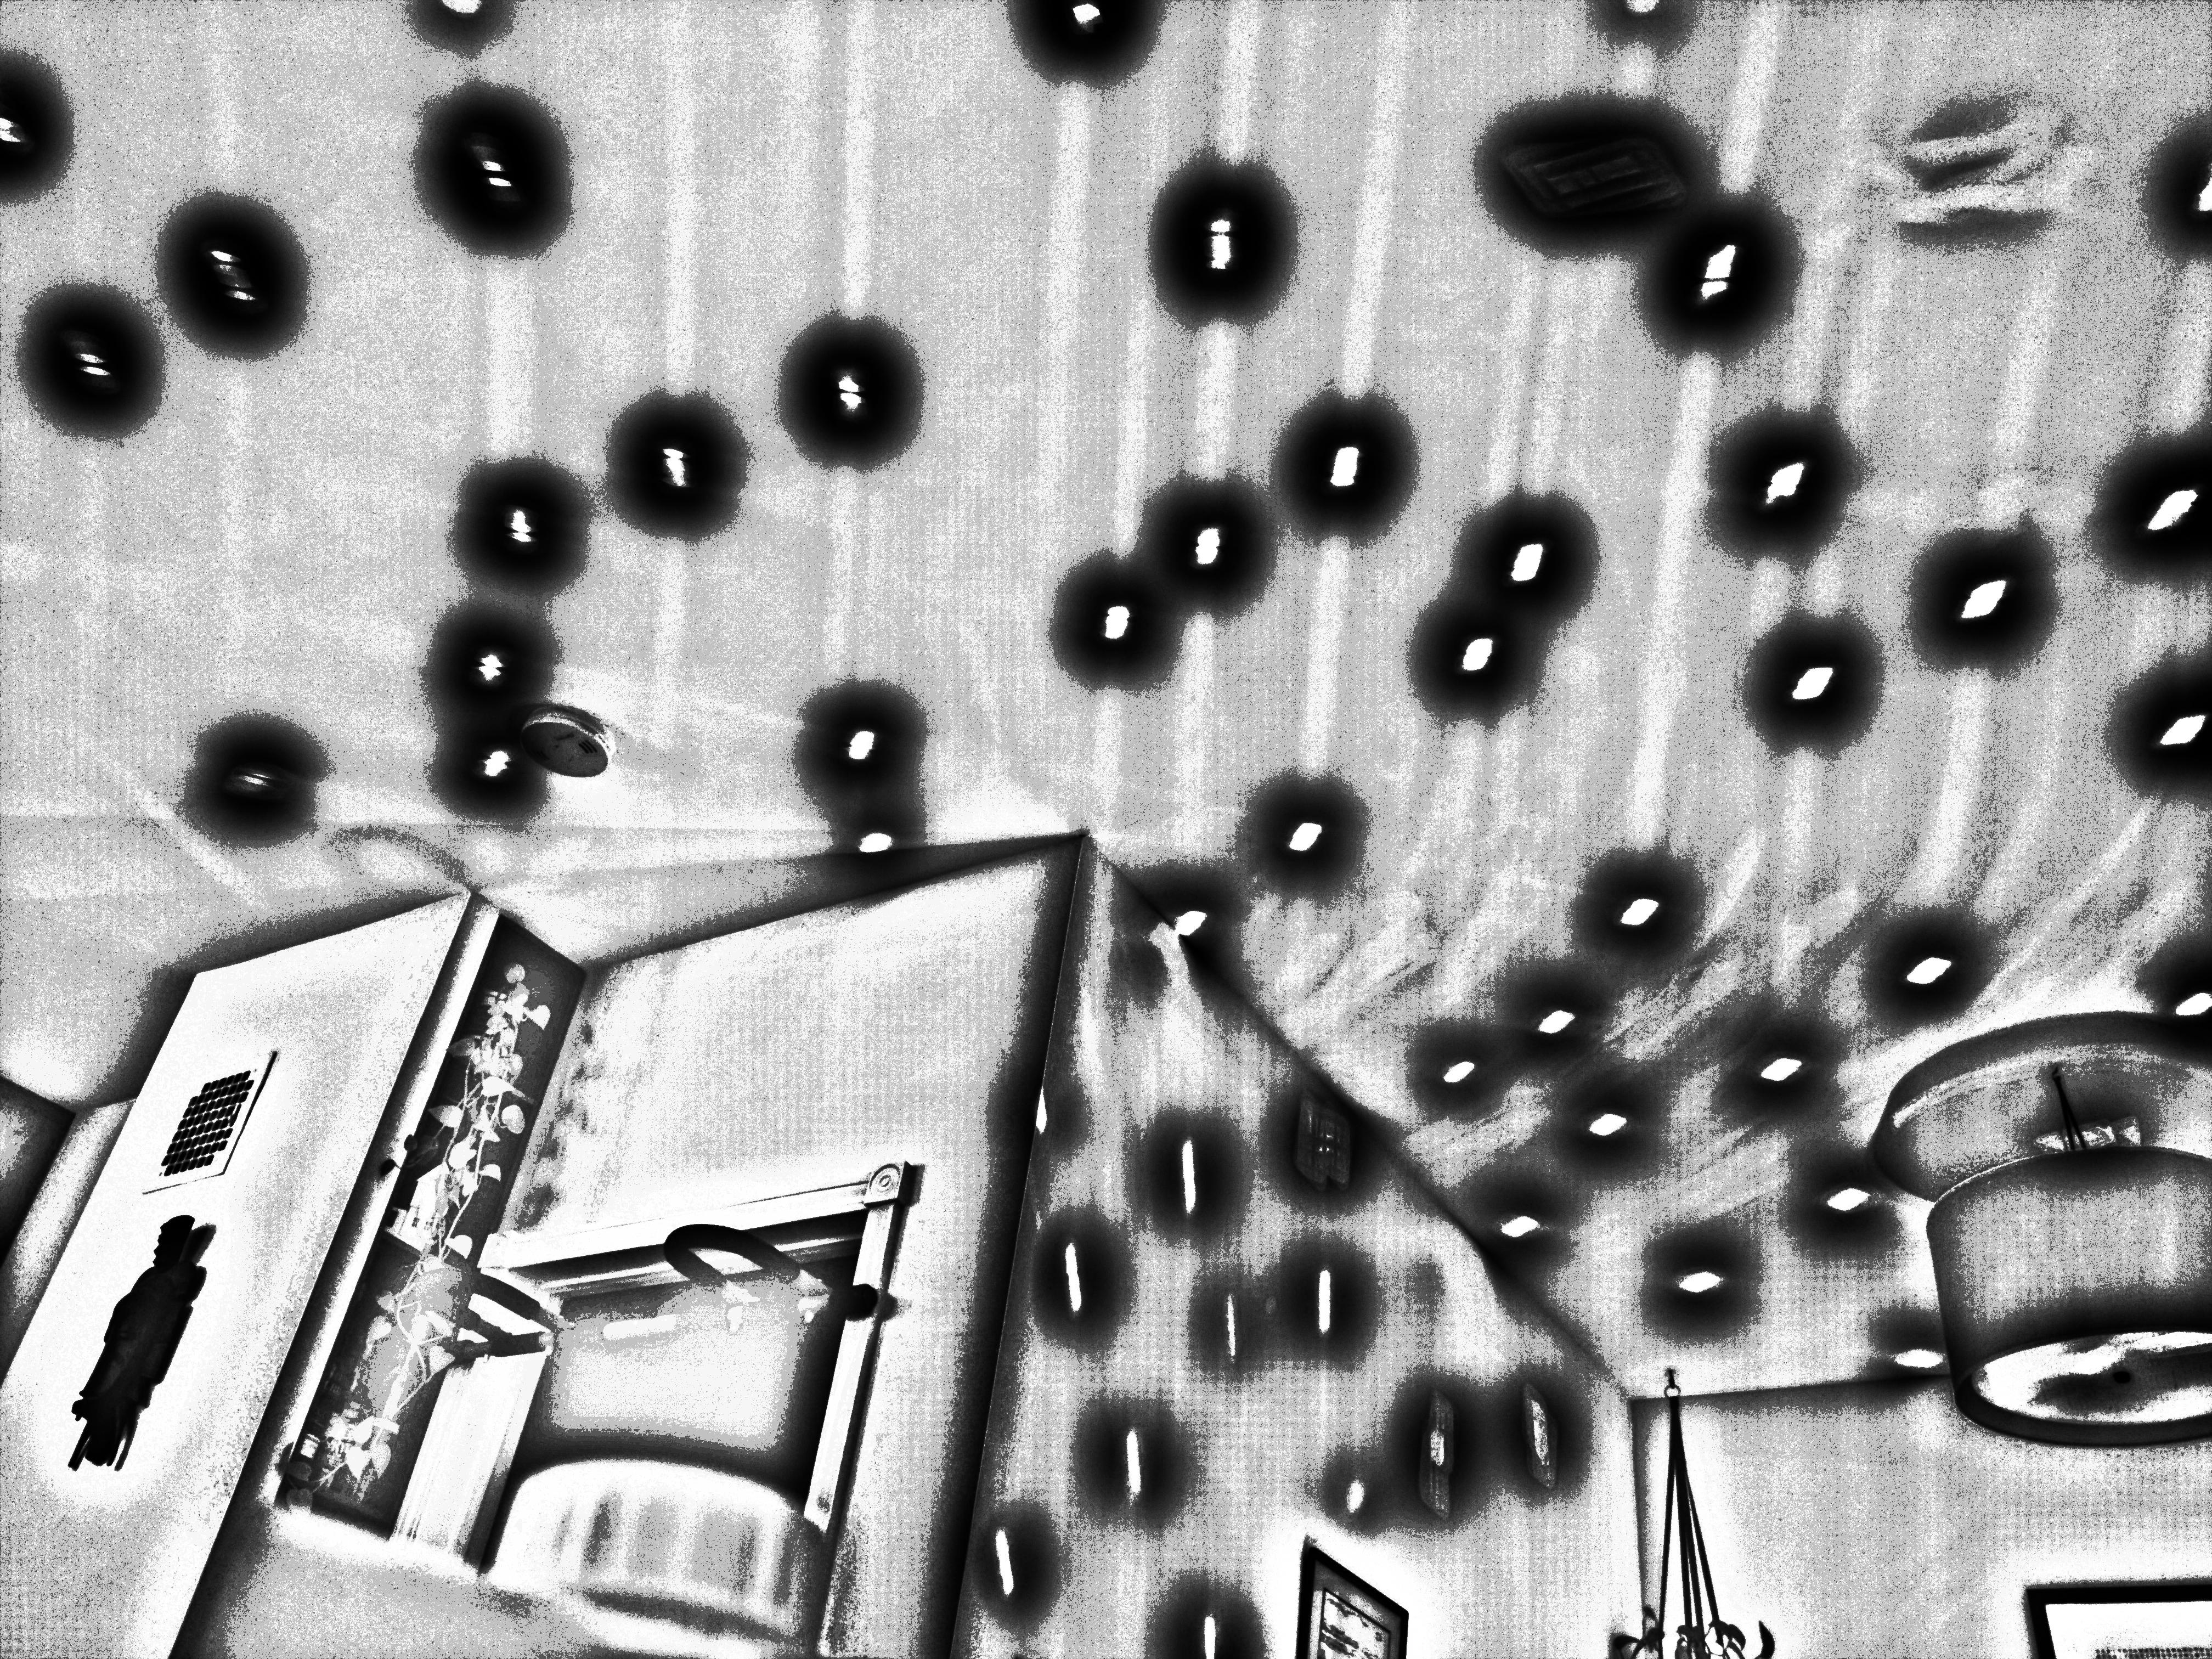

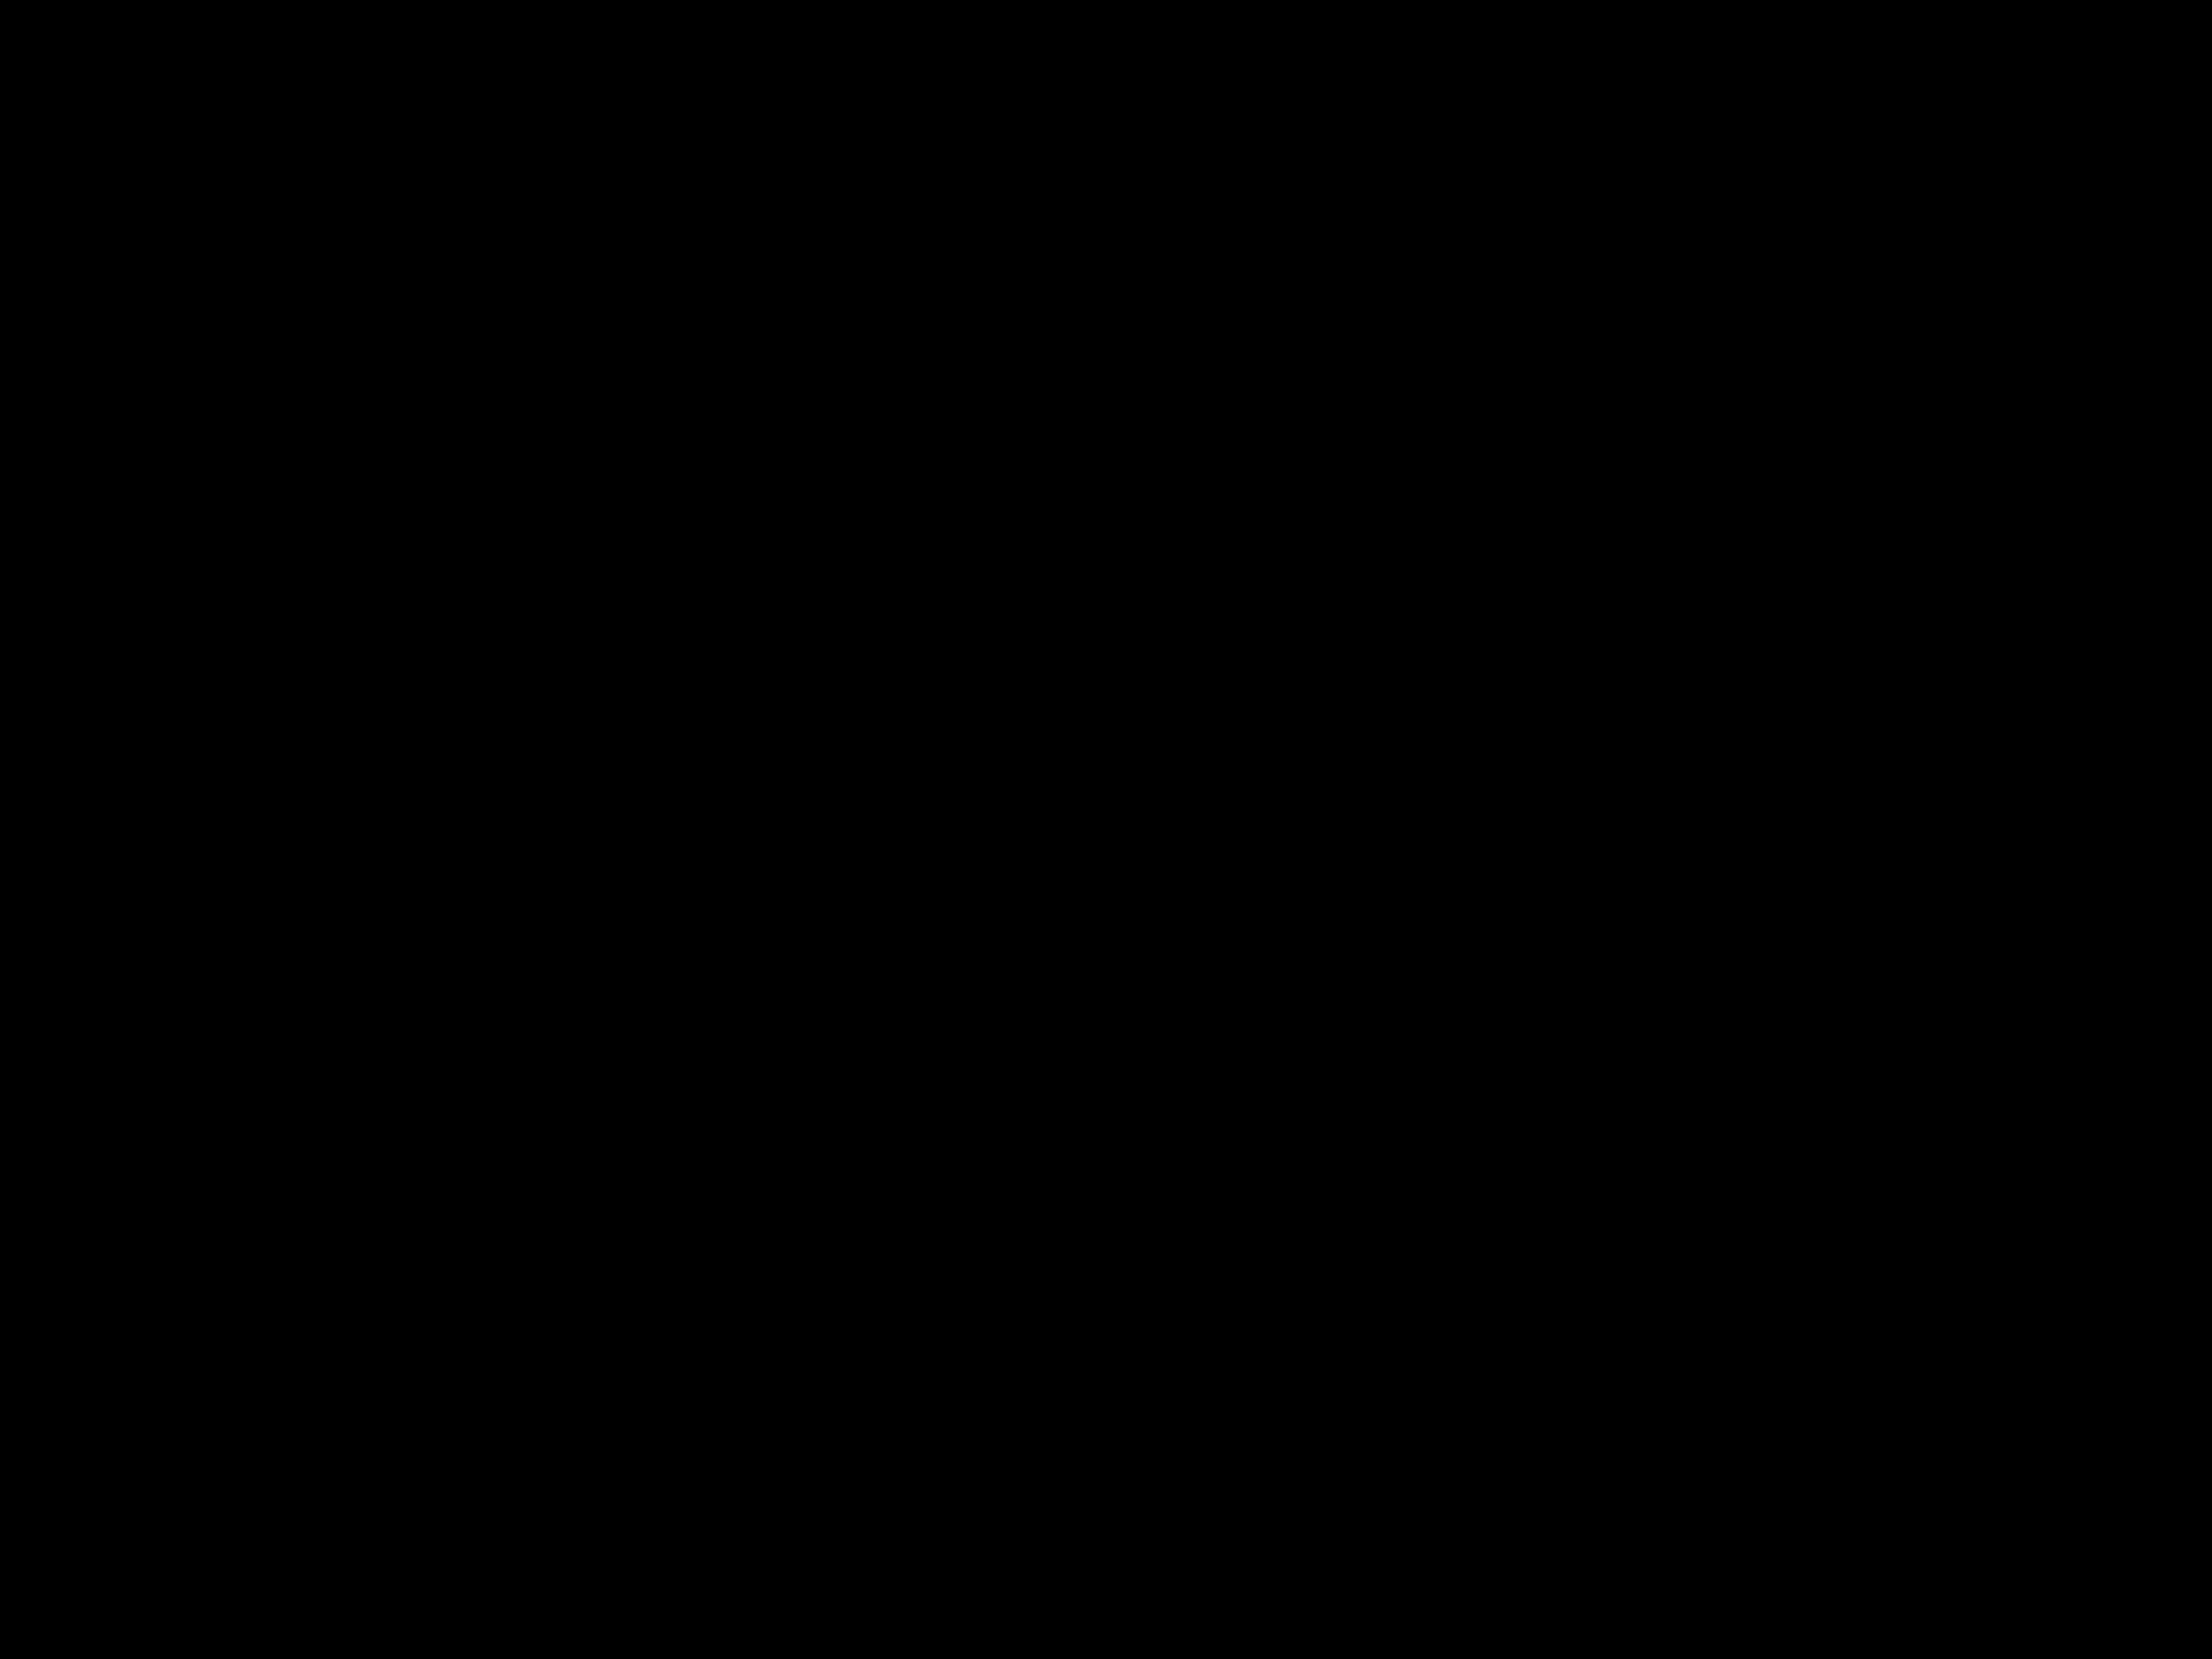

CPU times: user 480 ms, sys: 30 ms, total: 510 ms
Wall time: 495 ms
storing in ../SharedData/scan-1129T17-48-27/promap-301/


In [22]:
import re

force = True

folders = sorted([f for f in os.listdir(data_dir) if re.match(r'^scan-', f)])
print(folders)
# folders = folders[5:] 
# folders = [folders[0]]
print(folders)
# asdasd
for folder in folders:
    if not exists(folder) or force:
        try:
            print('load '+folder)
            %time load_scan(folder)
            print('calculate diff')
            calculate_difference()
            print('run pack')
            run_pack()
            print('build promap')
            run_build_promap()
            %time render_result()
            store_results(folder)
        except Exception as e: 
            print("Had to cancel ",folder)
            print(e)
    else: 
        print("Skipping %s since its already processed" % folder)

In [168]:
%matplotlib inline


sync_data()
# #Download data
# procams_folder = '/tmp/procams/'
# # !rm -rf {procams_folder}
# !mkdir -p {procams_folder}
# # !gsutil -m cp -r gs://{bucket}/processedScans/* {procams_folder}
# !gsutil -m rsync -r gs://{bucket}/ {procams_folder}
!ls {data_dir}

Building synchronization state...
Starting synchronization...
BuildXYZDebug.png    model.dae	scan-1512  scan-1529  settings.json
confidenceMap-0.exr  scan-1249	scan-1515  scan-1534  shader
_mask-0.png	     scan-1255	scan-1521  scan-1539  SharedData
mask-0.png	     scan-1338	scan-1524  scan-1541  xyzMap-0.exr
